# I] Import and options


In [1]:
import pandas, numpy, seaborn, scipy, scipy.stats
import matplotlib, matplotlib.pyplot as plt

In [2]:
matplotlib.rcParams.update({'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20, 
                            'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',
                            'figure.figsize':(12, 8), 'svg.fonttype' : 'none'})

In [3]:
input_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7//0 in_silico/Python/1)data_input/'
output_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/3)output/'

# II] DL data

## A) Extracellular Acidification Rate 

In [22]:
path = input_file_directory + 'mefs/mef_mitotracker/'
path2 = output_file_directory + 'ATG7/MEF_HuH7/Mitotracker/'

In [35]:
data = "number_mito_exp1", "number_mito_exp2", "number_mito_exp3"
conditions = 'DMSO+FCCP', 'BAF+FCCP'

mito_dmso_baf = []
for file in data: 
    #download data
    df_brut = pandas.read_csv(path+file+".csv", sep = ",")
    
    for condition in conditions:
        #split dmso/baf
        df = df_brut.loc[df_brut['condition'] == condition]
        df = df.assign(mean_EVd= df['ATG7-/- +dox'].mean())
        df = df.assign(EVnorm= df['mean_EVd']/ df['mean_EVd'],
                                 ATG7_1norm= df['ATG7(1)']/ df['mean_EVd'],
                                 ATG7_2norm= df['ATG7(2)']/ df['mean_EVd'])
        df = df.rename(columns = {'ATG7_1norm' : 'ATG7(1)',
                                  'ATG7_2norm' : 'ATG7(2)'})
        df = (df.iloc[:,9:]
              .dropna(axis=0))
        mito_dmso_baf.append(df)

mito_dmso = pandas.concat([mito_dmso_baf[0], mito_dmso_baf[2], mito_dmso_baf[4]], axis=0)
mito_dmso.loc['condition'] = "DMSO+FCCP"
mito_baf = pandas.concat([mito_dmso_baf[1], mito_dmso_baf[3], mito_dmso_baf[5]], axis=0)
mito_baf.loc['condition'] = "BAF+FCCP"

# group BAF and DMSO df
for df in mito_dmso, mito_baf:
    df.reset_index(drop=True, inplace=True)

df_mitochondria = pandas.concat([mito_dmso, mito_baf], axis=1)

# remove EVNorm column
# df_mitochondria =  df_mitochondria.drop('EVnorm', axis = 1) 
df_mitochondria

,EVnorm,ATG7(1),ATG7(2),EVnorm,ATG7(1),ATG7(2)
0,1.0,1.089776,1.08974,1.0,0.904579,0.93346
1,1.0,0.882325,0.983207,1.0,0.921929,0.931589
2,1.0,0.998413,1.021507,1.0,0.92985,0.915043
3,1.0,1.045509,1.064229,1.0,0.891094,0.932765
4,1.0,1.047431,1.075008,1.0,0.992971,0.978013
5,1.0,0.890579,0.938398,1.0,0.993661,0.912729
6,1.0,1.036593,1.016651,1.0,1.009324,0.967157
7,1.0,1.031766,1.048268,1.0,1.192126,1.069328
8,1.0,1.099255,1.108737,1.0,0.970596,0.972688
9,1.0,1.021362,1.002996,1.0,0.962522,0.978327


In [36]:
# Rotate and convert wide to long df
df_mitochondria = df_mitochondria.T
df_mitochondria.reset_index(inplace=True)
df_mitochondria = df_mitochondria.rename(columns={df_mitochondria.columns[13]: 'condition'})

df_mitochondria = df_mitochondria.melt(id_vars=["index", "condition"], var_name="measure (4per exp)")
df_mitochondria['value'] = df_mitochondria['value'].astype(float)
df_mitochondria

,index,condition,measure (4per exp),value
0,EVnorm,DMSO+FCCP,0,1.000000
1,ATG7(1),DMSO+FCCP,0,1.089776
2,ATG7(2),DMSO+FCCP,0,1.089740
3,EVnorm,BAF+FCCP,0,1.000000
4,ATG7(1),BAF+FCCP,0,0.904579
...,...,...,...,...
67,ATG7(1),DMSO+FCCP,11,1.025814
68,ATG7(2),DMSO+FCCP,11,0.983180
69,EVnorm,BAF+FCCP,11,1.000000
70,ATG7(1),BAF+FCCP,11,1.080177


In [41]:
# Statistic
conditions = "DMSO+FCCP", "BAF+FCCP"

for condition in conditions:
    print(condition.upper())   
    
    df = df_mitochondria.loc[df_mitochondria['condition'] == condition]

    df = df.sort_values(['index'], ascending = True)
    df.reset_index(drop=True, inplace=True)
    print(df.head(), '\n', df.tail(), '\n')

    # define label and separate mutants
    iso1_label = df.iloc[0]['index']
    df_iso1 = df.iloc[0:12, :]
    
    iso2_label = df.iloc[12]['index']
    df_iso2 = df.iloc[12:24, :]    

    ev_label = df.iloc[24]['index']   
    df_ev = df.iloc[24:, :]

    # Statistique, Ttest
    ### ATG7 isoform
    statistic, pvalue = scipy.stats.ttest_ind(df_ev['value'], df_iso1['value'])
    print("the pvalue between", ev_label, "and", iso1_label,"is", "{:.5E}".format(pvalue))
    
    statistic, pvalue = scipy.stats.ttest_ind(df_ev['value'], df_iso2['value'])
    print("the pvalue between", ev_label, "and", iso2_label,"is", "{:.5E}".format(pvalue))
    
    statistic, pvalue = scipy.stats.ttest_ind(df_iso1['value'], df_iso2['value'])
    print("the pvalue between", iso1_label, "and", iso2_label,"is", "{:.5E}".format(pvalue))
    
    print("-----------------------------------------------------")

DMSO+FCCP
     index  condition measure (4per exp)     value
0  ATG7(1)  DMSO+FCCP                 11  1.025814
1  ATG7(1)  DMSO+FCCP                  0  1.089776
2  ATG7(1)  DMSO+FCCP                  6  1.036593
3  ATG7(1)  DMSO+FCCP                 10  1.033605
4  ATG7(1)  DMSO+FCCP                  1  0.882325 
      index  condition measure (4per exp)  value
31  EVnorm  DMSO+FCCP                  8    1.0
32  EVnorm  DMSO+FCCP                  4    1.0
33  EVnorm  DMSO+FCCP                  7    1.0
34  EVnorm  DMSO+FCCP                  2    1.0
35  EVnorm  DMSO+FCCP                  0    1.0 

the pvalue between EVnorm and ATG7(1) is 3.91877E-01
the pvalue between EVnorm and ATG7(2) is 9.59824E-02
the pvalue between ATG7(1) and ATG7(2) is 7.13249E-01
-----------------------------------------------------
BAF+FCCP
     index condition measure (4per exp)     value
0  ATG7(1)  BAF+FCCP                 11  1.080177
1  ATG7(1)  BAF+FCCP                  0  0.904579
2  ATG7(1)  BAF+FCC

C:\Users\kja11\AppData\Local\Temp\ipykernel_21028\4018577274.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistic, pvalue = scipy.stats.ttest_ind(df_ev['value'], df_iso1['value'])
C:\Users\kja11\AppData\Local\Temp\ipykernel_21028\4018577274.py:28: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistic, pvalue = scipy.stats.ttest_ind(df_ev['value'], df_iso2['value'])
C:\Users\kja11\AppData\Local\Temp\ipykernel_21028\4018577274.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistic, pvalue = scipy.stats.ttest_ind(df_ev['value'], df_iso1['value'])
C:\Users\kja11\AppData\Local\Temp\ipykernel_21028

In [23]:
data = "number_mito_exp1", "number_mito_exp2", "number_mito_exp3"
conditions = 'DMSO+FCCP', 'BAF+FCCP'

mito_dmso_baf = []
for file in data: 
    #download data
    df_brut = pandas.read_csv(path+file+".csv", sep = ",")
    
    for condition in conditions:
        #split dmso/baf
        df = df_brut.loc[df_brut['condition'] == condition]
        df = df.assign(mean_EVd= df['ATG7-/- +dox'].mean())
        df = df.assign(EVnorm= df['mean_EVd']/ df['mean_EVd'],
                                 ATG7_1norm= df['ATG7(1)']/ df['mean_EVd'],
                                 ATG7_2norm= df['ATG7(2)']/ df['mean_EVd'])
        df = df.rename(columns = {'ATG7_1norm' : 'ATG7(1)',
                                  'ATG7_2norm' : 'ATG7(2)'})
        df = (df.iloc[:,9:]
              .dropna(axis=0))
        mito_dmso_baf.append(df)

mito_dmso = pandas.concat([mito_dmso_baf[0], mito_dmso_baf[2], mito_dmso_baf[4]], axis=0)
mito_dmso.loc['condition'] = "DMSO+FCCP"
mito_baf = pandas.concat([mito_dmso_baf[1], mito_dmso_baf[3], mito_dmso_baf[5]], axis=0)
mito_baf.loc['condition'] = "BAF+FCCP"

# group BAF and DMSO df
for df in mito_dmso, mito_baf:
    df.reset_index(drop=True, inplace=True)

df_mitochondria = pandas.concat([mito_dmso, mito_baf], axis=1)

# remove EVNorm column
df_mitochondria =  df_mitochondria.drop('EVnorm', axis = 1) 
df_mitochondria

,ATG7(1),ATG7(2),ATG7(1),ATG7(2)
0,1.089776,1.08974,0.904579,0.93346
1,0.882325,0.983207,0.921929,0.931589
2,0.998413,1.021507,0.92985,0.915043
3,1.045509,1.064229,0.891094,0.932765
4,1.047431,1.075008,0.992971,0.978013
5,0.890579,0.938398,0.993661,0.912729
6,1.036593,1.016651,1.009324,0.967157
7,1.031766,1.048268,1.192126,1.069328
8,1.099255,1.108737,0.970596,0.972688
9,1.021362,1.002996,0.962522,0.978327


In [25]:
# Rotate and convert wide to long df
df_mitochondria = df_mitochondria.T
df_mitochondria.reset_index(inplace=True)
df_mitochondria = df_mitochondria.rename(columns={df_mitochondria.columns[13]: 'condition'})

df_mitochondria = df_mitochondria.melt(id_vars=["index", "condition"], var_name="measure (4per exp)")
df_mitochondria['value'] = df_mitochondria['value'].astype(float)
df_mitochondria

,index,condition,measure (4per exp),value
0,ATG7(1),DMSO+FCCP,0,1.089776
1,ATG7(2),DMSO+FCCP,0,1.089740
2,ATG7(1),BAF+FCCP,0,0.904579
3,ATG7(2),BAF+FCCP,0,0.933460
4,ATG7(1),DMSO+FCCP,1,0.882325
5,ATG7(2),DMSO+FCCP,1,0.983207
6,ATG7(1),BAF+FCCP,1,0.921929
7,ATG7(2),BAF+FCCP,1,0.931589
8,ATG7(1),DMSO+FCCP,2,0.998413
9,ATG7(2),DMSO+FCCP,2,1.021507


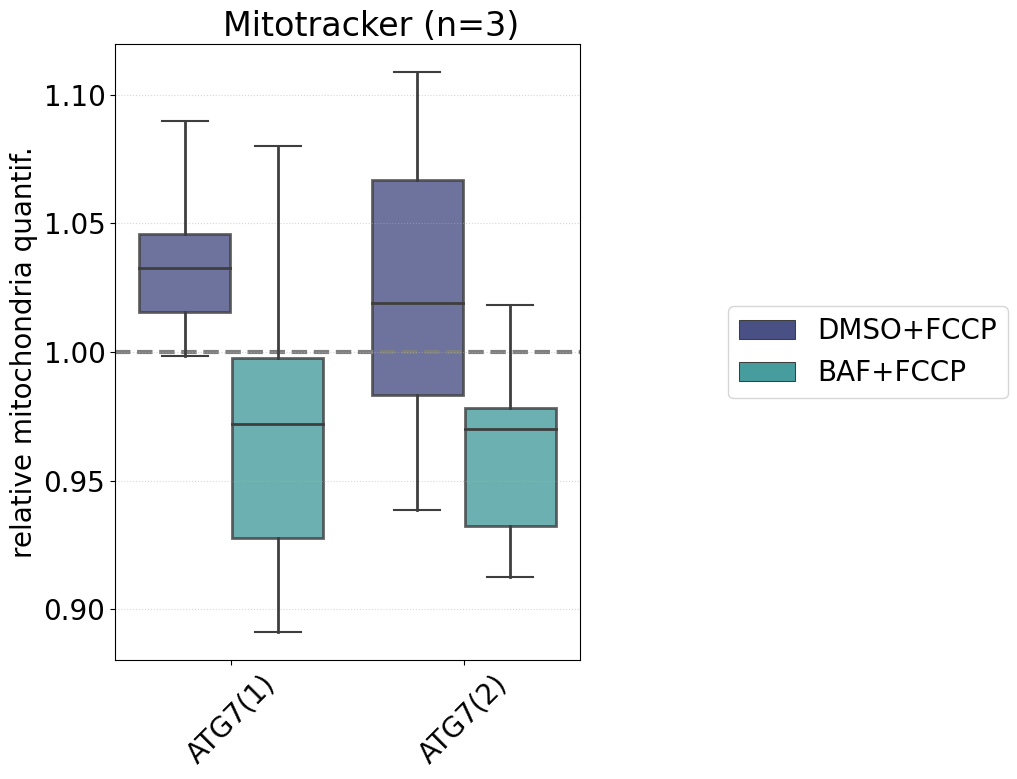

In [26]:
#graph
plt.figure(figsize=(6, 8))
fig = seaborn.boxplot(x="index", y="value", hue="condition", palette = 'mako', data = df_mitochondria, 
                      boxprops={'lw':2, 'alpha' : 0.8}, medianprops={'lw':2}, whiskerprops={'lw':2},
                      showcaps=True, showfliers=False)

# plt.tight_layout()
plt.axhline(y=1, ls='--', lw=3, color='tab:grey', zorder=1)
plt.ylabel('relative mitochondria quantif.')
plt.xlabel('')
plt.xticks(rotation = 45)
plt.title('Mitotracker' + ' (n=3)', x=.55)
plt.legend(loc='center right', fontsize=20, bbox_to_anchor=(1.95, 0.5))

#save
text_file = 'graph_all_mitotracker'
plt.savefig(path2+text_file+'.svg')

In [27]:
# Statistic
conditions = "DMSO+FCCP", "BAF+FCCP"

for condition in conditions:
    print(condition.upper())   
    
    df = df_mitochondria.loc[df_mitochondria['condition'] == condition]

    df = df.sort_values(['index'], ascending = True)
    df.reset_index(drop=True, inplace=True)
    print(df.head(), '\n')

    # define label and separate mutants
    iso1_label = df.iloc[0]['index']
    iso2_label = df.iloc[12]['index']

    df_iso1 = df.iloc[0:12, :]
    df_iso2 = df.iloc[12:, :]

    # Statistique, Ttest
    ### ATG7 isoform
    statistic, pvalue = scipy.stats.ttest_ind(df_iso1['value'], df_iso2['value'])
    print("the pvalue between", iso1_label, "and", iso2_label,"is", "{:.5E}".format(pvalue))
    print("-----------------------------------------------------")

DMSO+FCCP
     index  condition measure (4per exp)     value
0  ATG7(1)  DMSO+FCCP                  0  1.089776
1  ATG7(1)  DMSO+FCCP                  1  0.882325
2  ATG7(1)  DMSO+FCCP                 10  1.033605
3  ATG7(1)  DMSO+FCCP                  2  0.998413
4  ATG7(1)  DMSO+FCCP                  3  1.045509 

the pvalue between ATG7(1) and ATG7(2) is 7.13249E-01
-----------------------------------------------------
BAF+FCCP
     index condition measure (4per exp)     value
0  ATG7(1)  BAF+FCCP                  0  0.904579
1  ATG7(1)  BAF+FCCP                  1  0.921929
2  ATG7(1)  BAF+FCCP                 10  0.973287
3  ATG7(1)  BAF+FCCP                  2  0.929850
4  ATG7(1)  BAF+FCCP                  3  0.891094 

the pvalue between ATG7(1) and ATG7(2) is 4.71775E-01
-----------------------------------------------------
